# Random Forest

### 1. 필요한 Python 라이브러리 Import 하기

In [1]:
# pandas 임포트
import pandas as pd

# numpy 임포트
import numpy as np

# RandomForestRegressor를 임포트합니다.
from sklearn.ensemble import RandomForestRegressor

# train_test_split 임포트
from sklearn.model_selection import train_test_split

# cross_val_score 임포트
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

import pickle

# matplotlib 임포트
import matplotlib.pyplot as plt

# 경고 끄기
import warnings

warnings.filterwarnings("ignore")

### 2. 자전거 대여 데이터 읽기

In [2]:
# bike_rentals_cleaned.csv 파일을 로드합니다.
df_bikes = pd.read_csv("bike_rentals_cleaned.csv")

# 처음 다섯 개 행을 출력합니다.
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [3]:
# 데이터를 X와 y로 나눕니다.
X_bikes = df_bikes.iloc[:, :-1]
y_bikes = df_bikes.iloc[:, -1]

### 3. Random Forest를 활용한 성능평가

In [4]:
# RandomForestRegressor 객체를 만듭니다.
rf = RandomForestRegressor(n_estimators=50, random_state=2, n_jobs=-1)

# 평균 제곱 오차를 사용해 교차 검증을 수행합니다.
scores = cross_val_score(rf, X_bikes, y_bikes, scoring="neg_mean_squared_error", cv=5)

# 오차의 제곱근을 계산합니다.
rmse = np.sqrt(-scores)

# rmse를 출력합니다.
print("RMSE:", np.round(rmse, 3))

# 평균 rmse를 출력합니다.
print("RMSE 평균: %0.3f" % (rmse.mean()))

RMSE: [1108.25   661.194  934.381  904.553 1212.591]
RMSE 평균: 964.194


### 4. 랜덤 포레스트 성능 향상

#### 4.1 데이터셋 준비

In [5]:
# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

### 4.2 n_estimators

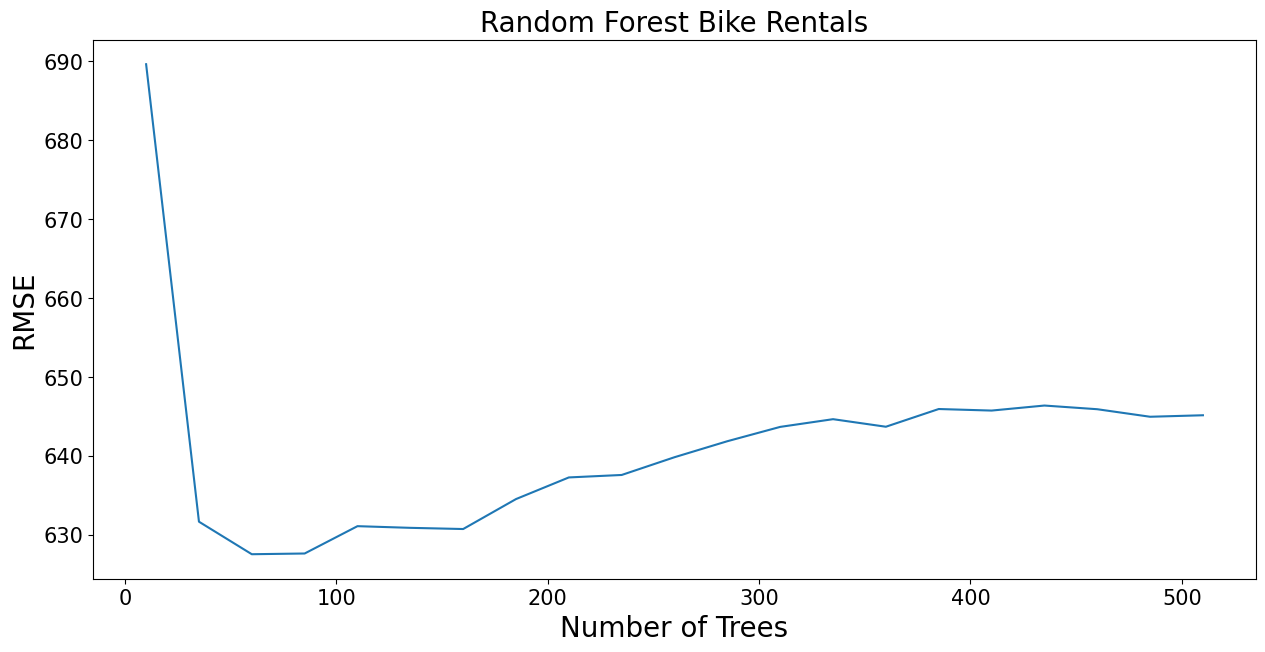

In [6]:
from sklearn.metrics import mean_squared_error

# MSE 점수와 트리 개수를 담을 리스트
rmse_scores = []
estimators = []

# warm_start=True로 RandomForestRegressor 객체를 만듭니다.
rf = RandomForestRegressor(warm_start=True, n_jobs=-1, random_state=2)

# 시작 트리 개수
est = 10

# 0~19까지 반복합니다.
for i in range(21):

    # n_estimators를 est로 설정합니다.
    rf.set_params(n_estimators=est)

    # 인구 조사 데이터셋으로 훈련합니다.
    rf.fit(X_train, y_train)

    # RMSE 값을 계산합니다.
    rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)

    # rmse와 est를 리스트에 추가합니다.
    rmse_scores.append(rmse)
    estimators.append(est)

    # 트리를 25개씩 늘립니다.
    est += 25

# 그래프 크기를 설정합니다.
plt.figure(figsize=(15, 7))

# estimators와 rmse_scores를 그래프로 그립니다.
plt.plot(estimators, rmse_scores)

# 축 레이블을 설정합니다.
plt.xlabel("Number of Trees", fontsize=20)
plt.ylabel("RMSE", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 제목을 출력합니다.
plt.title("Random Forest Bike Rentals", fontsize=20)

# 그래프를 출력합니다.
plt.show()

### 4.3 cross_val_score

In [7]:
# n_estimators=50, warm_start=True, oob_score=True로 랜덤 포레스트 모델을 만듭니다.
rf = RandomForestRegressor(n_estimators=50, warm_start=True, n_jobs=-1, random_state=2)

# 평균 제곱 오차를 사용해 교차 검증을 수행합니다.
scores = cross_val_score(rf, X_bikes, y_bikes, scoring="neg_mean_squared_error", cv=10)

# 오차의 제곱근을 계산합니다.
rmse = np.sqrt(-scores)

# rmse를 출력합니다.
print("RMSE:", np.round(rmse, 3))

# 평균 rmse를 출력합니다.
print("RMSE 평균: %0.3f" % (rmse.mean()))

RMSE: [ 836.482  541.898  533.086  812.782  894.877  881.117  794.103  828.968
  772.517 2128.148]
RMSE 평균: 902.398


### 4.4 하이퍼파라미터 튜닝

In [8]:
# RandomizedSearchCV 임포트
from sklearn.model_selection import RandomizedSearchCV


def randomized_search_reg(
    params, runs=16, reg=RandomForestRegressor(random_state=2, n_jobs=-1)
):

    # RandomizedSearchCV 객체를 만듭니다.
    rand_reg = RandomizedSearchCV(
        reg,
        params,
        n_iter=runs,
        scoring="neg_mean_squared_error",
        cv=10,
        n_jobs=-1,
        random_state=2,
    )

    # X_train와 y_train로 grid_reg를 훈련합니다.
    rand_reg.fit(X_train, y_train)

    # 최상의 모델을 추출합니다.
    best_model = rand_reg.best_estimator_

    # 최상의 매개변수를 추출합니다.
    best_params = rand_reg.best_params_

    # 최상의 매개변수를 출력합니다.
    print("최상의 매개변수:", best_params)

    # 최상의 점수를 구합니다.
    best_score = np.sqrt(-rand_reg.best_score_)

    # 최상의 점수를 출력합니다.
    print("훈련 점수: {:.3f}".format(best_score))

    # 테스트 세트의 레이블을 예측합니다.
    y_pred = best_model.predict(X_test)

    # mean_squared_error를 임포트합니다.
    from sklearn.metrics import mean_squared_error as MSE

    # rmse를 계산합니다.
    rmse_test = MSE(y_test, y_pred) ** 0.5

    # rmse를 출력합니다.
    print("테스트 세트 점수: {:.3f}".format(rmse_test))

In [9]:
randomized_search_reg(
    params={
        "min_weight_fraction_leaf": [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05],
        "min_samples_split": [2, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],
        "min_samples_leaf": [1, 2, 4, 6, 8, 10, 20, 30],
        "min_impurity_decrease": [0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
        "max_leaf_nodes": [10, 15, 20, 25, 30, 35, 40, 45, 50, None],
        "max_features": ["sqrt", 0.8, 0.7, 0.6, 0.5, 0.4],
        "max_depth": [None, 2, 4, 6, 8, 10, 20],
    }
)

최상의 매개변수: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.03, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': 25, 'max_features': 0.7, 'max_depth': None}
훈련 점수: 759.076
테스트 세트 점수: 701.802


In [10]:
randomized_search_reg(
    params={
        "min_samples_leaf": [1, 2, 4, 6, 8, 10, 20, 30],
        "min_impurity_decrease": [0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
        "max_features": ["sqrt", 0.8, 0.7, 0.6, 0.5, 0.4],
        "max_depth": [None, 2, 4, 6, 8, 10, 20],
    }
)

최상의 매개변수: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 10}
훈련 점수: 679.052
테스트 세트 점수: 626.541


In [11]:
randomized_search_reg(
    params={
        "min_samples_leaf": [1, 2, 4, 6, 8, 10, 20, 30],
        "min_impurity_decrease": [0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
        "max_features": ["sqrt", 0.8, 0.7, 0.6, 0.5, 0.4],
        "max_depth": [None, 4, 6, 8, 10, 12, 15, 20],
    },
    runs=20,
)

최상의 매개변수: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 12}
훈련 점수: 675.128
테스트 세트 점수: 619.014


In [12]:
randomized_search_reg(
    params={
        "min_samples_leaf": [1, 2, 3, 4, 5, 6],
        "min_impurity_decrease": [0.0, 0.01, 0.05, 0.08, 0.10, 0.12, 0.15],
        "max_features": ["sqrt", 0.8, 0.7, 0.6, 0.5, 0.4],
        "max_depth": [None, 8, 10, 12, 14, 16, 18, 20],
    }
)

최상의 매개변수: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.05, 'max_features': 0.7, 'max_depth': 18}
훈련 점수: 679.595
테스트 세트 점수: 630.954


In [13]:
randomized_search_reg(
    params={
        "min_samples_leaf": [1, 2, 4, 6, 8, 10, 20, 30],
        "min_impurity_decrease": [0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
        "max_features": ["sqrt", 0.8, 0.7, 0.6, 0.5, 0.4],
        "max_depth": [None, 4, 6, 8, 10, 12, 15, 20],
        "n_estimators": [100],
    },
    runs=20,
)

최상의 매개변수: {'n_estimators': 100, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 12}
훈련 점수: 675.128
테스트 세트 점수: 619.014


In [14]:
# n_estimators=100, oob_score=True으로 랜덤 포레스트 모델을 만듭니다.
rf = RandomForestRegressor(
    n_estimators=100,
    min_impurity_decrease=0.1,
    max_features=0.6,
    max_depth=12,
    n_jobs=-1,
    random_state=2,
)

# 평균 제곱 오차를 사용해 교차 검증을 수행합니다.
scores = cross_val_score(rf, X_bikes, y_bikes, scoring="neg_mean_squared_error", cv=10)

# 오차의 제곱근을 계산합니다.
rmse = np.sqrt(-scores)

# rmse를 출력합니다.
print("RMSE:", np.round(rmse, 3))

# 평균 rmse를 출력합니다.
print("RMSE 평균: %0.3f" % (rmse.mean()))

RMSE: [ 818.354  514.173  547.392  814.059  769.54   730.025  831.376  794.634
  756.83  1595.237]
RMSE 평균: 817.162


### 5. Best 모델 저장


In [15]:
rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_leaf=1,
    min_impurity_decrease=0.1,
    max_features=0.6,
    max_depth=12,
    n_jobs=-1,
    random_state=2,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# rmse를 계산합니다.
rmse_test = MSE(y_test, y_pred) ** 0.5

# rmse를 출력합니다.
print("테스트 세트 점수: {:.3f}".format(rmse_test))

테스트 세트 점수: 619.014


In [ ]:
with open("rf_ex1.pickle", "wb") as f:
    pickle.dump(rf, f)

### 6. 저장된 모델 불러와서 사용하기


In [ ]:
import pickle

with open("rf_ex1.pickle", "rb") as f:
    rf_model = pickle.load(f)

In [18]:
# 테스트 세트의 레이블을 예측합니다.
y_pred = rf_model.predict(X_test)

# rmse를 계산합니다.
rmse_test = MSE(y_test, y_pred) ** 0.5

# rmse를 출력합니다.
print("테스트 세트 점수: {:.3f}".format(rmse_test))

테스트 세트 점수: 619.014
